In [2]:
import os

from fastai.vision.all import *
from fastai.vision import *

import pandas as pd

In [3]:
TRAIN_DATASET_PATH = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset'
TEST_DATASET_PATH = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/trichome_dataset'


In [ ]:
# models to compare 
available_models = {
    'resnet34': models.resnet34,
    'resnet50': models.resnet50,
    'resnet101': models.resnet101,
    'resnet152': models.resnet152,
    'resnext50_32x4d': models.resnext50_32x4d,
    'resnext101_32x8d': models.resnext101_32x8d,
    'wide_resnet50_2': models.wide_resnet50_2,
    'wide_resnet101_2': models.wide_resnet101_2,
    'vgg16_bn': models.vgg16_bn,
    'vgg19_bn': models.vgg19_bn,
    'squeezenet1_1': models.squeezenet1_1,
    'vgg16_bn': models.vgg16_bn,
    'vgg19_bn': models.vgg19_bn,
    'densenet121': models.densenet121,
    'densenet169': models.densenet169,
    'densenet201': models.densenet201,
    'densenet161': models.densenet161,
}

In [47]:
# create csv for the trichome dataset
class_names = []
for folder_name in os.listdir(TEST_DATASET_PATH):
    class_names.append(folder_name)
    
print(f"classes names:\n {class_names}")

image_paths = []
labels = []

for i in range(len(class_names)):
    class_name = class_names[i]
    image_names = os.listdir(f'{TEST_DATASET_PATH}/{class_name}')
    for image_name in image_names:
        image_path = f'{TEST_DATASET_PATH}/{class_name}/{image_name}'
        image_paths.append(image_path)
        labels.append(i)
        
        
df = pd.DataFrame(
    {
        'name': image_paths,
        'label': labels
    }
)

# if you want to save the to csv
# df.to_csv(
#     path_or_buf=f'{TRAIN_DATASET_PATH}/labels.csv',
#     index=False
# )

df.head()

In [53]:
# dist of the df data
df['label'].value_counts()

label
1    232
0    216
2     77
Name: count, dtype: int64

## Images Transformation Experiment
I want to compare the results when performing transformations like resize or color shifting for the images to see if I can get better results.
I will use a slim model to run the comparisons faster.

In [24]:
# model and metrics to compare
model_name = 'resnet34'
precision_macro = Precision(average='macro')
recall_macro = Recall(average='macro')
precision_micro = Precision(average='micro')
recall_micro = RecallMulti(average='micro')
roc_auc = RocAuc()


Raw dataloader

In [41]:
# create raw dataloader
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=Resize(128),
    bs=16,
    valid_pct=0.25
)

# if you want to see a sample of the data
# dls.show_batch()

In [44]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.459068,1.174221,0.427788,0.545757,0.550889,0.709838,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.084724,0.903926,0.341865,0.646656,0.642280,0.782210,00:04
1,0.907598,0.858765,0.332724,0.670691,0.647670,0.805444,00:04
2,0.745361,0.901603,0.338208,0.652682,0.645580,0.809109,00:04
3,0.650743,0.904548,0.323583,0.678016,0.645909,0.815037,00:04
4,0.645943,0.946854,0.347349,0.660784,0.638756,0.814700,00:04
5,0.545256,0.977793,0.323583,0.690069,0.638763,0.811875,00:04
6,0.497936,0.930665,0.356490,0.644886,0.607149,0.804449,00:04
7,0.414045,1.040586,0.334552,0.693488,0.643640,0.804074,00:04
8,0.342403,0.902106,0.325411,0.699959,0.614227,0.825781,00:04
9,0.311198,0.995935,0.319927,0.697767,0.622994,0.815269,00:04


Resize the Image to 128 with padding

In [45]:
import PIL

# Custom transform
def custom_transform(size):
    return Resize(size, method='pad', pad_mode='zeros')

# DataLoaders with custom transform
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=custom_transform(128),  # Adjust size as needed
    batch_tfms=aug_transforms(size=128),  # Apply data augmentation
    bs=16,
    valid_pct=0.25
)


# if you want to see a sample of the data
# dls.show_batch()

In [46]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.585254,1.227656,0.427788,0.563135,0.547723,0.734548,00:05


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.231721,0.874349,0.343693,0.636860,0.661927,0.792645,00:06
1,1.043655,0.865813,0.367459,0.622273,0.610897,0.798102,00:05
2,0.961187,0.855111,0.371115,0.629846,0.613344,0.799246,00:05
3,0.961301,0.890444,0.356490,0.661711,0.662150,0.795200,00:05
4,0.869433,0.877300,0.345521,0.660604,0.648854,0.801853,00:05
5,0.766256,0.695348,0.343693,0.705397,0.632298,0.836058,00:05
6,0.701299,0.791918,0.352834,0.704706,0.594252,0.814234,00:05
7,0.659042,0.798436,0.338208,0.641133,0.662409,0.831156,00:05
8,0.631873,0.699159,0.305302,0.699513,0.689909,0.849819,00:05
9,0.593867,0.715662,0.296161,0.690573,0.696598,0.843808,00:05


Convert the images to HSV

In [47]:
# Custom Transform to HSV using fastai's rgb2hsv
class RGB2HSV(Transform):
    def encodes(self, img: PILImage): 
        return rgb2hsv(img)
    
# DataLoaders with custom transform to HSV
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=Resize(128),  # Resize before applying HSV transform
    batch_tfms=[RGB2HSV(), *aug_transforms(size=128)],
    bs=16,
    valid_pct=0.25
)

# Check a batch to see if transformations are applied correctly
# dls.show_batch()


In [48]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.543482,1.053026,0.407678,0.552505,0.584303,0.758932,00:05


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.230895,0.855508,0.347349,0.645093,0.658531,0.791309,00:05
1,1.119144,0.803274,0.325411,0.688834,0.669267,0.807718,00:05
2,0.963601,0.752917,0.299817,0.704776,0.687470,0.833186,00:05
3,0.930227,0.686148,0.312614,0.691036,0.715819,0.864145,00:05
4,0.842901,0.734984,0.299817,0.701633,0.708033,0.840069,00:05
5,0.770539,0.672049,0.307130,0.735780,0.645989,0.848442,00:05
6,0.702882,0.678054,0.261426,0.751877,0.719858,0.863620,00:05
7,0.702857,0.672966,0.283364,0.723510,0.706803,0.852130,00:05
8,0.634815,0.634992,0.307130,0.707003,0.673530,0.864418,00:05
9,0.581727,0.673483,0.272395,0.741121,0.742084,0.874019,00:05


Normalize the images pixels

In [49]:
# DataLoaders with custom transform to HSV
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=Resize(128),  # Resize before applying HSV transform
    batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms(size=128)],
    bs=16,
    valid_pct=0.25
)

# Check a batch to see if transformations are applied correctly
# dls.show_batch()


In [50]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.732388,1.104942,0.389397,0.567709,0.611454,0.755376,00:05


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.261801,0.848266,0.321755,0.642124,0.676323,0.809954,00:05
1,1.109568,0.818226,0.349177,0.628893,0.675801,0.822057,00:06
2,0.964629,0.776504,0.338208,0.631468,0.661511,0.831591,00:06
3,0.932905,0.765294,0.321755,0.633548,0.657773,0.837569,00:05
4,0.872124,0.685920,0.299817,0.696263,0.672213,0.844776,00:06
5,0.840126,0.789051,0.323583,0.642546,0.717136,0.829740,00:06
6,0.731988,0.640600,0.285192,0.722483,0.694947,0.858040,00:07
7,0.687337,0.709821,0.303474,0.681538,0.704702,0.859539,00:08
8,0.654730,0.630237,0.308958,0.687002,0.679414,0.861265,00:06
9,0.606821,0.749408,0.314442,0.652629,0.714622,0.857255,00:05


Brightness and Contrast Adjustments

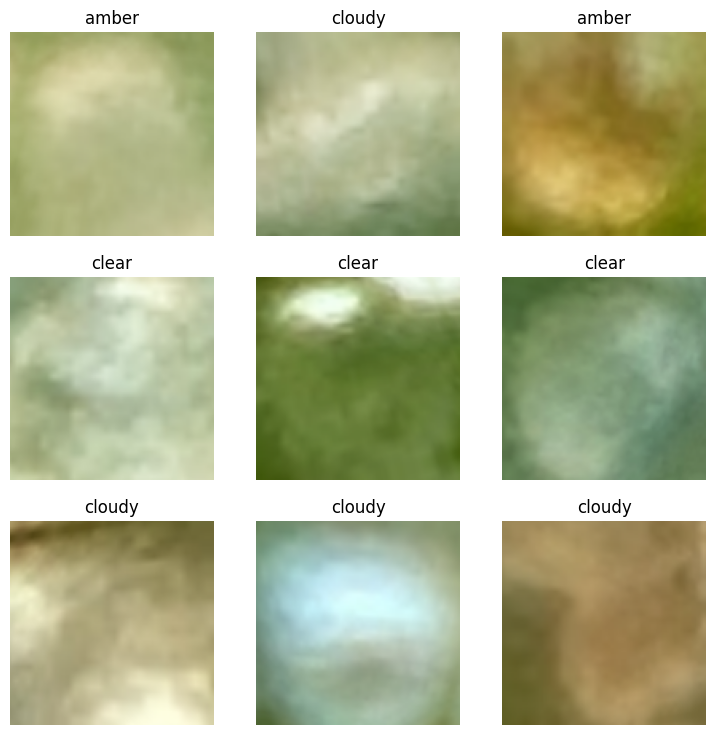

In [53]:
# DataLoaders with custom transform to HSV
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=Resize(128), 
    batch_tfms=[Brightness(max_lighting=0.2, p=0.75), Contrast(max_lighting=0.2, p=0.75), *aug_transforms(size=128)],
    bs=16,
    valid_pct=0.25
)

# Check a batch to see if transformations are applied correctly
dls.show_batch()


In [52]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.604066,1.138211,0.382084,0.613353,0.626446,0.765438,00:06


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.244024,0.883623,0.356490,0.655182,0.648677,0.803721,00:06
1,1.108567,0.823120,0.330896,0.656467,0.690912,0.821352,00:06
2,0.974461,0.786989,0.319927,0.674209,0.682375,0.827640,00:07
3,0.990939,0.815781,0.307130,0.694943,0.694226,0.823158,00:07
4,0.886123,0.688135,0.310786,0.686382,0.674465,0.846319,00:06
5,0.804609,0.694007,0.319927,0.681322,0.701187,0.844205,00:06
6,0.742754,0.722755,0.279707,0.716032,0.715185,0.867318,00:06
7,0.680805,0.764495,0.323583,0.699638,0.689597,0.835456,00:07
8,0.668954,0.638936,0.305302,0.696729,0.728653,0.863100,00:07
9,0.633175,0.606152,0.277879,0.722525,0.734931,0.875443,00:06


Combined Transformations

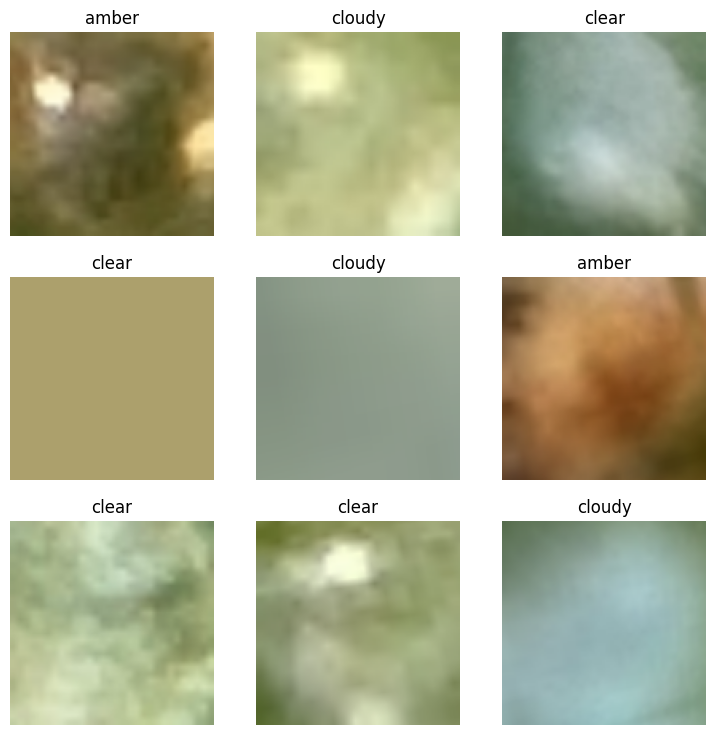

In [55]:
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=custom_transform(size=128),  # Resize and HSV transform
    batch_tfms=[
        RGB2HSV(),
        *aug_transforms(size=128, flip_vert=True, max_rotate=10),
        Brightness(max_lighting=0.2, p=0.75),
        Contrast(max_lighting=0.2, p=0.75),
    ],
    bs=16,
    valid_pct=0.25
)

# Check a batch to see if transformations are applied correctly
dls.show_batch()

In [56]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.545772,1.179755,0.391225,0.575086,0.623426,0.763160,00:05


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.172613,0.917406,0.354662,0.607664,0.641910,0.819787,00:05
1,1.123695,0.836722,0.332724,0.645917,0.637336,0.830438,00:06
2,0.997973,0.740655,0.307130,0.674299,0.675552,0.844593,00:06
3,0.978702,0.740064,0.329068,0.673903,0.676513,0.844343,00:05
4,0.925984,0.777038,0.303474,0.680224,0.706087,0.849066,00:06
5,0.813459,0.694614,0.279707,0.729323,0.697065,0.859209,00:06
6,0.754030,0.670959,0.288848,0.724385,0.704108,0.851680,00:06
7,0.736590,0.633308,0.283364,0.714538,0.690149,0.874171,00:06
8,0.701513,0.634199,0.297989,0.728288,0.676351,0.864213,00:06
9,0.636530,0.582150,0.274223,0.765461,0.707068,0.883462,00:06


In [73]:
model_saving_path = '/home/etaylor/code_projects/thesis/checkpoints/image_classification_models'
model_checkpoint = f'{model_saving_path}/{model_name}.pkl'
model.export(model_checkpoint)

### Evaluate the Model

In [57]:
from sklearn.metrics import precision_score, recall_score, accuracy_score


item_tfms=custom_transform(size=128),  # Resize and HSV transform
batch_tfms=[
    RGB2HSV(),
    *aug_transforms(size=128, flip_vert=True, max_rotate=10),
    Brightness(max_lighting=0.2, p=0.75),
    Contrast(max_lighting=0.2, p=0.75),
]

# Create the test DataLoader with the same transformations
test_dl = dls.test_dl(get_image_files(TEST_DATASET_PATH), with_labels=True, 
                    item_tfms=item_tfms, batch_tfms=batch_tfms)


# Evaluate on the test set
preds, targs = model.get_preds(dl=test_dl)


if targs is not None:
    pred_classes = preds.argmax(dim=1).numpy()
    true_classes = targs.numpy()

    precision = precision_score(true_classes, pred_classes, average='macro')
    recall = recall_score(true_classes, pred_classes, average='macro')
    accuracy = accuracy_score(true_classes, pred_classes)
else:
    precision = recall = accuracy = None

results = {
    'model': model_name,
    'precision': precision,
    'recall': recall,
    'accuracy': accuracy
}

results

{'model': 'resnet34',
 'precision': 0.7645257817058765,
 'recall': 0.7558770518540633,
 'accuracy': 0.7352380952380952}

### Compare Different Models
In this section I will compare different Image classification models with the datasets created.

In [ ]:
# lets bring the models and datasets 
available_models = {
    'resnet34': models.resnet34,
    'resnet50': models.resnet50,
    'resnet101': models.resnet101,
    'resnet152': models.resnet152,
    'resnext50_32x4d': models.resnext50_32x4d,
    'resnext101_32x8d': models.resnext101_32x8d,
    'wide_resnet50_2': models.wide_resnet50_2,
    'wide_resnet101_2': models.wide_resnet101_2,
    'vgg16_bn': models.vgg16_bn,
    'vgg19_bn': models.vgg19_bn,
    'squeezenet1_1': models.squeezenet1_1,
    'densenet121': models.densenet121,
    'densenet169': models.densenet169,
    'densenet201': models.densenet201,
}

dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=custom_transform(size=128),  # Resize and HSV transform
    batch_tfms=[
        RGB2HSV(),
        *aug_transforms(size=128, flip_vert=True, max_rotate=10),
        Brightness(max_lighting=0.2, p=0.75),
        Contrast(max_lighting=0.2, p=0.75),
    ],
    bs=16,
    valid_pct=0.25
)

# Check a batch to see if transformations are applied correctly
dls.show_batch()

In [58]:
#Iterate over each model and train, then evaluate on the test set and save the results
results = []

for model_name, model_fn in available_models.items():
    print(f"Training model: {model_name}")
    
    model = vision_learner(
        dls=dls,
        arch=model_fn,
        metrics=[error_rate, precision_macro, recall_macro, roc_auc]
    )

    model.fine_tune(
        epochs=25
    )

    # Create the test DataLoader with the same transformations
    test_dl = dls.test_dl(get_image_files(TEST_DATASET_PATH), with_labels=True, 
                        item_tfms=item_tfms, batch_tfms=batch_tfms)

    # Evaluate on the test set
    preds, targs = model.get_preds(dl=test_dl)

    if targs is not None:
        pred_classes = preds.argmax(dim=1).numpy()
        true_classes = targs.numpy()

        precision = precision_score(true_classes, pred_classes, average='macro')
        recall = recall_score(true_classes, pred_classes, average='macro')
        accuracy = accuracy_score(true_classes, pred_classes)
    else:
        precision = recall = accuracy = None

    results.append({
        'model': model_name,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy
    })
    
    print(f"Results for model {model_name}:")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print("\n\n")

Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.533937,1.083718,0.383912,0.574066,0.609376,0.791755,00:05


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.293079,0.942960,0.340037,0.634722,0.683247,0.813881,00:05
1,1.106510,0.872925,0.321755,0.669556,0.673826,0.812958,00:06
2,1.006903,0.767997,0.325411,0.682474,0.664440,0.833392,00:06
3,0.923980,0.856393,0.343693,0.642621,0.655490,0.818552,00:05
4,0.862746,0.772802,0.330896,0.685194,0.666818,0.840664,00:05
5,0.813832,0.736311,0.318099,0.694516,0.644217,0.836994,00:06
6,0.804296,0.683751,0.277879,0.718839,0.724297,0.860691,00:06
7,0.737512,0.648531,0.303474,0.699328,0.663879,0.859689,00:05
8,0.692696,0.639396,0.276051,0.740078,0.712315,0.873256,00:05
9,0.637972,0.616064,0.255942,0.758465,0.725496,0.880181,00:05


Results for model resnet34:
Precision: 0.765919889515395
Recall: 0.7200051970166913
Accuracy: 0.7123809523809523



Training model: resnet50


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.842298,1.403274,0.449726,0.500225,0.518928,0.707697,00:07


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.423620,1.005751,0.402194,0.559141,0.555657,0.754797,00:07
1,1.252503,0.881113,0.378428,0.582859,0.574266,0.780417,00:08
2,1.115856,0.794559,0.319927,0.669710,0.599448,0.789697,00:07
3,1.002515,0.738318,0.321755,0.652752,0.632671,0.823442,00:07
4,0.947573,0.758219,0.367459,0.614527,0.570219,0.818193,00:08
5,0.827198,0.686608,0.314442,0.695935,0.640604,0.838762,00:08
6,0.829144,0.728756,0.343693,0.702017,0.597541,0.820237,00:08
7,0.758718,0.666602,0.307130,0.706931,0.665240,0.844525,00:08
8,0.757412,0.678852,0.319927,0.698776,0.642365,0.840473,00:08
9,0.696732,0.693484,0.341865,0.656729,0.630545,0.830306,00:08


Results for model resnet50:
Precision: 0.7246559110381915
Recall: 0.6218617482985298
Accuracy: 0.6552380952380953



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.830363,1.740114,0.464351,0.479063,0.498123,0.663748,00:09


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.380986,1.188783,0.431444,0.517909,0.513211,0.696356,00:13
1,1.188806,1.175282,0.431444,0.552912,0.521453,0.706732,00:13
2,1.073762,1.134253,0.394881,0.578397,0.574428,0.750121,00:13
3,1.018361,1.011879,0.378428,0.614326,0.540953,0.752535,00:13
4,0.944142,1.112962,0.378428,0.640210,0.546327,0.760163,00:13
5,0.883382,0.791187,0.334552,0.648642,0.587194,0.800461,00:13
6,0.775776,1.187575,0.376600,0.616104,0.579022,0.752144,00:13
7,0.790102,0.769156,0.351005,0.654755,0.621777,0.819130,00:13
8,0.730335,1.368469,0.356490,0.652289,0.618817,0.766544,00:13
9,0.706636,0.984652,0.345521,0.637457,0.588555,0.815876,00:13


Results for model resnet101:
Precision: 0.7712738174617607
Recall: 0.6743177533407417
Accuracy: 0.700952380952381



Training model: resnet152


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.843110,1.422043,0.488117,0.462330,0.485469,0.681749,00:12


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.414485,1.095808,0.429616,0.528261,0.550046,0.732464,00:18
1,1.258322,0.951421,0.418647,0.566165,0.563226,0.752835,00:18
2,1.140124,0.917088,0.433272,0.543839,0.554184,0.749989,00:18
3,1.064240,0.845658,0.361974,0.627460,0.591985,0.782646,00:18
4,0.979880,0.734016,0.332724,0.681098,0.628350,0.812921,00:18
5,0.881116,0.727959,0.338208,0.680169,0.617238,0.820420,00:18
6,0.823367,0.778742,0.361974,0.642795,0.588191,0.798574,00:18
7,0.779777,0.764184,0.345521,0.631600,0.586703,0.812046,00:18
8,0.696849,0.666129,0.299817,0.707963,0.657397,0.846488,00:18
9,0.719933,0.653429,0.303474,0.715540,0.667092,0.851449,00:18


Results for model resnet152:
Precision: 0.7503153270091865
Recall: 0.6657530421898238
Accuracy: 0.6819047619047619



Training model: resnext50_32x4d


/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /home/etaylor/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:02<00:00, 47.3MB/s]


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.785075,1.591572,0.444241,0.511873,0.549246,0.726076,00:08


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.314028,1.059713,0.363803,0.637965,0.606871,0.760304,00:11
1,1.230443,0.865850,0.356490,0.635400,0.633976,0.804400,00:11
2,1.051977,0.865500,0.360146,0.633033,0.587138,0.775210,00:12
3,1.020993,0.796959,0.352834,0.679463,0.590225,0.796338,00:11
4,0.961463,0.793996,0.352834,0.655184,0.616530,0.804638,00:12
5,0.867846,0.810775,0.347349,0.666569,0.586086,0.790815,00:11
6,0.809415,0.709744,0.336380,0.666277,0.627424,0.829866,00:11
7,0.769134,0.687808,0.312614,0.707989,0.659684,0.839427,00:12
8,0.724178,0.751421,0.292505,0.709619,0.682342,0.836427,00:12
9,0.663015,0.710510,0.312614,0.736862,0.647394,0.844254,00:12


Results for model resnext50_32x4d:
Precision: 0.7453229808078885
Recall: 0.6852694984878892
Accuracy: 0.6876190476190476



Training model: resnext101_32x8d


/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /home/etaylor/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:04<00:00, 81.6MB/s] 


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.635553,1.598132,0.440585,0.512075,0.527262,0.712760,00:20


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.216816,0.986799,0.358318,0.629013,0.626442,0.788295,00:30
1,1.069109,0.930109,0.360146,0.654864,0.623973,0.793018,00:30
2,1.018603,0.817764,0.318099,0.668102,0.658450,0.811524,00:30
3,0.911623,0.735760,0.301645,0.696909,0.684720,0.839424,00:30
4,0.873331,0.737827,0.312614,0.710491,0.650607,0.822947,00:30
5,0.816622,0.748391,0.319927,0.664156,0.696736,0.838241,00:30
6,0.747540,0.646053,0.287020,0.720678,0.702130,0.864543,00:30
7,0.737626,0.635434,0.288848,0.744532,0.676751,0.866996,00:30
8,0.657234,0.658021,0.296161,0.732268,0.686971,0.866177,00:30
9,0.654671,0.617989,0.268739,0.738230,0.704872,0.874344,00:30


Results for model resnext101_32x8d:
Precision: 0.7259949826290274
Recall: 0.6992143658810326
Accuracy: 0.6933333333333334



Training model: wide_resnet50_2


/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /home/etaylor/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:02<00:00, 68.5MB/s] 


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.892203,1.696646,0.451554,0.494988,0.499939,0.689779,00:08


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.345131,1.071478,0.405850,0.569949,0.539263,0.759149,00:13
1,1.135438,0.963425,0.393053,0.580208,0.539537,0.768316,00:13
2,1.134501,0.876118,0.404022,0.610326,0.563934,0.771314,00:13
3,1.012753,0.890140,0.371115,0.628340,0.612336,0.779557,00:13
4,0.964957,0.811181,0.369287,0.610232,0.571580,0.782038,00:13
5,0.884309,0.779798,0.372943,0.617422,0.602950,0.801806,00:13
6,0.838657,0.816327,0.358318,0.646130,0.595072,0.792954,00:13
7,0.801324,0.700528,0.341865,0.681170,0.624646,0.832197,00:13
8,0.720190,0.746126,0.343693,0.693605,0.600192,0.830067,00:13
9,0.689402,0.704351,0.319927,0.724125,0.631527,0.839429,00:13


Results for model wide_resnet50_2:
Precision: 0.7447244784201307
Recall: 0.6291866392441104
Accuracy: 0.6666666666666666



Training model: wide_resnet101_2


/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /home/etaylor/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth
100%|██████████| 243M/243M [00:06<00:00, 37.8MB/s] 


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.871160,2.383536,0.447898,0.489777,0.487958,0.681812,00:13


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.374970,1.624085,0.402194,0.559402,0.566586,0.747550,00:21
1,1.105687,1.126871,0.383912,0.628310,0.566459,0.750287,00:21
2,1.063151,0.964572,0.396709,0.589016,0.565134,0.771747,00:21
3,0.969764,0.977629,0.376600,0.618073,0.569019,0.773038,00:21
4,0.926489,1.031236,0.347349,0.638763,0.558020,0.773499,00:21
5,0.926580,0.941730,0.340037,0.680881,0.609796,0.788535,00:21
6,0.826306,0.988528,0.358318,0.627011,0.567749,0.796776,00:21
7,0.783899,0.886735,0.354662,0.662435,0.599828,0.784198,00:21
8,0.726545,0.746120,0.314442,0.717906,0.639987,0.823565,00:21
9,0.691107,0.749482,0.312614,0.704219,0.629766,0.829067,00:21


Results for model wide_resnet101_2:
Precision: 0.7278149396513647
Recall: 0.6745333742460179
Accuracy: 0.6914285714285714



Training model: vgg16_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.502588,1.210559,0.402194,0.568343,0.581036,0.733634,00:06


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.175540,1.015207,0.391225,0.586539,0.598846,0.790915,00:08
1,1.096082,0.892088,0.352834,0.638939,0.641075,0.813612,00:08
2,1.004867,0.836085,0.338208,0.654604,0.636192,0.829086,00:08
3,0.904320,0.806432,0.327239,0.688211,0.616677,0.831030,00:08
4,0.878174,0.793859,0.336380,0.666871,0.616894,0.830041,00:08
5,0.756074,0.723065,0.308958,0.719242,0.690710,0.863804,00:08
6,0.719000,0.700885,0.299817,0.680570,0.695340,0.855960,00:08
7,0.689602,0.689335,0.296161,0.743089,0.680981,0.860530,00:08
8,0.671307,0.663566,0.299817,0.698010,0.647667,0.864655,00:08
9,0.649249,0.677195,0.303474,0.718811,0.679038,0.867847,00:08


Results for model vgg16_bn:
Precision: 0.770439355629435
Recall: 0.7185310964046595
Accuracy: 0.7180952380952381



Training model: vgg19_bn


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /home/etaylor/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:06<00:00, 85.4MB/s] 


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.653667,1.205771,0.387569,0.586504,0.588934,0.756035,00:07


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.240546,0.954878,0.341865,0.668966,0.626498,0.817757,00:09
1,1.141540,0.915547,0.378428,0.624720,0.598811,0.814964,00:09
2,1.065688,0.899901,0.369287,0.671476,0.583217,0.808247,00:09
3,0.970488,0.952730,0.383912,0.684932,0.571797,0.802416,00:09
4,0.858834,0.773360,0.352834,0.693200,0.605475,0.841745,00:09
5,0.818261,0.875281,0.351005,0.693387,0.605783,0.826589,00:09
6,0.769471,0.722633,0.340037,0.684846,0.620416,0.845435,00:09
7,0.721471,0.715152,0.305302,0.743320,0.620745,0.861229,00:09
8,0.663345,0.726903,0.345521,0.698260,0.655889,0.856900,00:09
9,0.625734,0.743516,0.312614,0.723723,0.600430,0.856389,00:09


Results for model vgg19_bn:
Precision: 0.7506832534617899
Recall: 0.6459518557219707
Accuracy: 0.6780952380952381



Training model: squeezenet1_1


Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /home/etaylor/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 13.7MB/s]


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.483290,1.035230,0.416819,0.550509,0.586971,0.739949,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.133740,0.818267,0.301645,0.671767,0.724858,0.848317,00:04
1,0.997525,0.734294,0.299817,0.743565,0.645507,0.847397,00:04
2,0.977333,0.756108,0.325411,0.689253,0.646721,0.824410,00:04
3,0.962053,0.686386,0.305302,0.706339,0.662953,0.843575,00:04
4,0.923274,0.791500,0.321755,0.682446,0.641657,0.814332,00:04
5,0.895978,0.788473,0.343693,0.654459,0.654781,0.818352,00:04
6,0.853909,0.720872,0.290676,0.696235,0.682433,0.828937,00:04
7,0.828231,0.711599,0.296161,0.726895,0.668200,0.828014,00:04
8,0.795937,1.223030,0.367459,0.654364,0.666454,0.823804,00:04
9,0.739820,0.980588,0.323583,0.686407,0.651842,0.837764,00:04


Results for model squeezenet1_1:
Precision: 0.7437245194010504
Recall: 0.6985384772741096
Accuracy: 0.700952380952381



Training model: densenet121


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.545080,1.215119,0.429616,0.525244,0.494930,0.719511,00:11


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.196837,0.935926,0.340037,0.689990,0.618038,0.807302,00:14
1,1.077839,0.802672,0.327239,0.689499,0.656507,0.829096,00:14
2,1.000717,0.838855,0.330896,0.702026,0.606274,0.812067,00:14
3,0.924577,0.810948,0.343693,0.662458,0.625172,0.812341,00:14
4,0.870329,0.762469,0.361974,0.678521,0.612826,0.816903,00:14
5,0.783497,0.765310,0.319927,0.723635,0.625627,0.843609,00:14
6,0.780312,0.769270,0.340037,0.692709,0.609796,0.821522,00:14
7,0.743698,0.745544,0.341865,0.706364,0.655581,0.846999,00:14
8,0.671427,0.676484,0.308958,0.739146,0.674717,0.860250,00:14
9,0.636490,0.740113,0.297989,0.749689,0.674064,0.854246,00:14


Results for model densenet121:
Precision: 0.768659215865734
Recall: 0.6865784279577382
Accuracy: 0.7028571428571428



Training model: densenet169


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /home/etaylor/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:01<00:00, 35.7MB/s]


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.541100,1.186518,0.429616,0.543109,0.573973,0.745528,00:15


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.208822,0.838878,0.327239,0.689423,0.656198,0.822084,00:19
1,1.058073,0.823747,0.316271,0.695230,0.667927,0.839300,00:19
2,0.935244,0.751729,0.332724,0.701932,0.660737,0.837058,00:19
3,0.854711,0.681616,0.314442,0.701509,0.689294,0.852666,00:19
4,0.819619,0.647488,0.288848,0.720481,0.704200,0.859962,00:19
5,0.772943,0.673595,0.294333,0.741033,0.646124,0.857338,00:19
6,0.742591,0.802012,0.308958,0.751754,0.629240,0.821960,00:19
7,0.709908,0.644033,0.294333,0.722001,0.699443,0.880537,00:19
8,0.654653,0.579972,0.283364,0.763019,0.703147,0.882244,00:19
9,0.623850,0.668335,0.296161,0.736722,0.636121,0.866901,00:19


Results for model densenet169:
Precision: 0.7813666078304732
Recall: 0.72707991242474
Accuracy: 0.7314285714285714



Training model: densenet201


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /home/etaylor/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:01<00:00, 44.6MB/s]


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.710563,1.331001,0.418647,0.591090,0.606942,0.777884,00:18


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.115512,0.927098,0.367459,0.626469,0.632741,0.818480,00:23
1,1.018959,0.834295,0.330896,0.672967,0.667744,0.835500,00:23
2,0.892284,0.834859,0.299817,0.720865,0.713186,0.855647,00:23
3,0.897462,0.763294,0.332724,0.692952,0.633505,0.827260,00:23
4,0.814068,0.755933,0.327239,0.738398,0.668979,0.820566,00:23
5,0.722782,0.723687,0.305302,0.718854,0.685028,0.857417,00:23
6,0.719606,0.703404,0.347349,0.718136,0.611248,0.833660,00:23
7,0.662837,0.667091,0.287020,0.733717,0.657762,0.860751,00:23
8,0.633587,0.751146,0.314442,0.707440,0.608490,0.846532,00:23
9,0.598800,0.630158,0.305302,0.737239,0.661010,0.870740,00:23


Results for model densenet201:
Precision: 0.7618595359559216
Recall: 0.7075371946061603
Accuracy: 0.6914285714285714



Training model: densenet161


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /home/etaylor/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 68.5MB/s] 


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.731508,1.190772,0.361974,0.601400,0.637280,0.799835,00:15


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.059541,0.930276,0.323583,0.680394,0.659158,0.834484,00:19
1,0.934270,0.895977,0.308958,0.680486,0.678947,0.848937,00:19
2,0.879254,0.826159,0.314442,0.705495,0.680399,0.845076,00:19
3,0.837303,0.754508,0.283364,0.736970,0.675825,0.832991,00:19
4,0.871963,0.796379,0.310786,0.669872,0.681633,0.844271,00:19
5,0.801162,0.796314,0.308958,0.729559,0.688241,0.838896,00:19
6,0.737104,0.653306,0.301645,0.712246,0.688641,0.863691,00:19
7,0.664910,0.640144,0.268739,0.741117,0.731178,0.882416,00:19
8,0.577208,0.635747,0.265082,0.772568,0.732412,0.890527,00:19
9,0.572609,0.716207,0.305302,0.701572,0.702257,0.863529,00:19


Results for model densenet161:
Precision: 0.7231549355385036
Recall: 0.727814543906498
Accuracy: 0.7028571428571428





In [59]:
results

[{'model': 'resnet34',
  'precision': 0.765919889515395,
  'recall': 0.7200051970166913,
  'accuracy': 0.7123809523809523},
 {'model': 'resnet50',
  'precision': 0.7246559110381915,
  'recall': 0.6218617482985298,
  'accuracy': 0.6552380952380953},
 {'model': 'resnet101',
  'precision': 0.7712738174617607,
  'recall': 0.6743177533407417,
  'accuracy': 0.700952380952381},
 {'model': 'resnet152',
  'precision': 0.7503153270091865,
  'recall': 0.6657530421898238,
  'accuracy': 0.6819047619047619},
 {'model': 'resnext50_32x4d',
  'precision': 0.7453229808078885,
  'recall': 0.6852694984878892,
  'accuracy': 0.6876190476190476},
 {'model': 'resnext101_32x8d',
  'precision': 0.7259949826290274,
  'recall': 0.6992143658810326,
  'accuracy': 0.6933333333333334},
 {'model': 'wide_resnet50_2',
  'precision': 0.7447244784201307,
  'recall': 0.6291866392441104,
  'accuracy': 0.6666666666666666},
 {'model': 'wide_resnet101_2',
  'precision': 0.7278149396513647,
  'recall': 0.6745333742460179,
  'ac

<Figure size 1400x800 with 0 Axes>

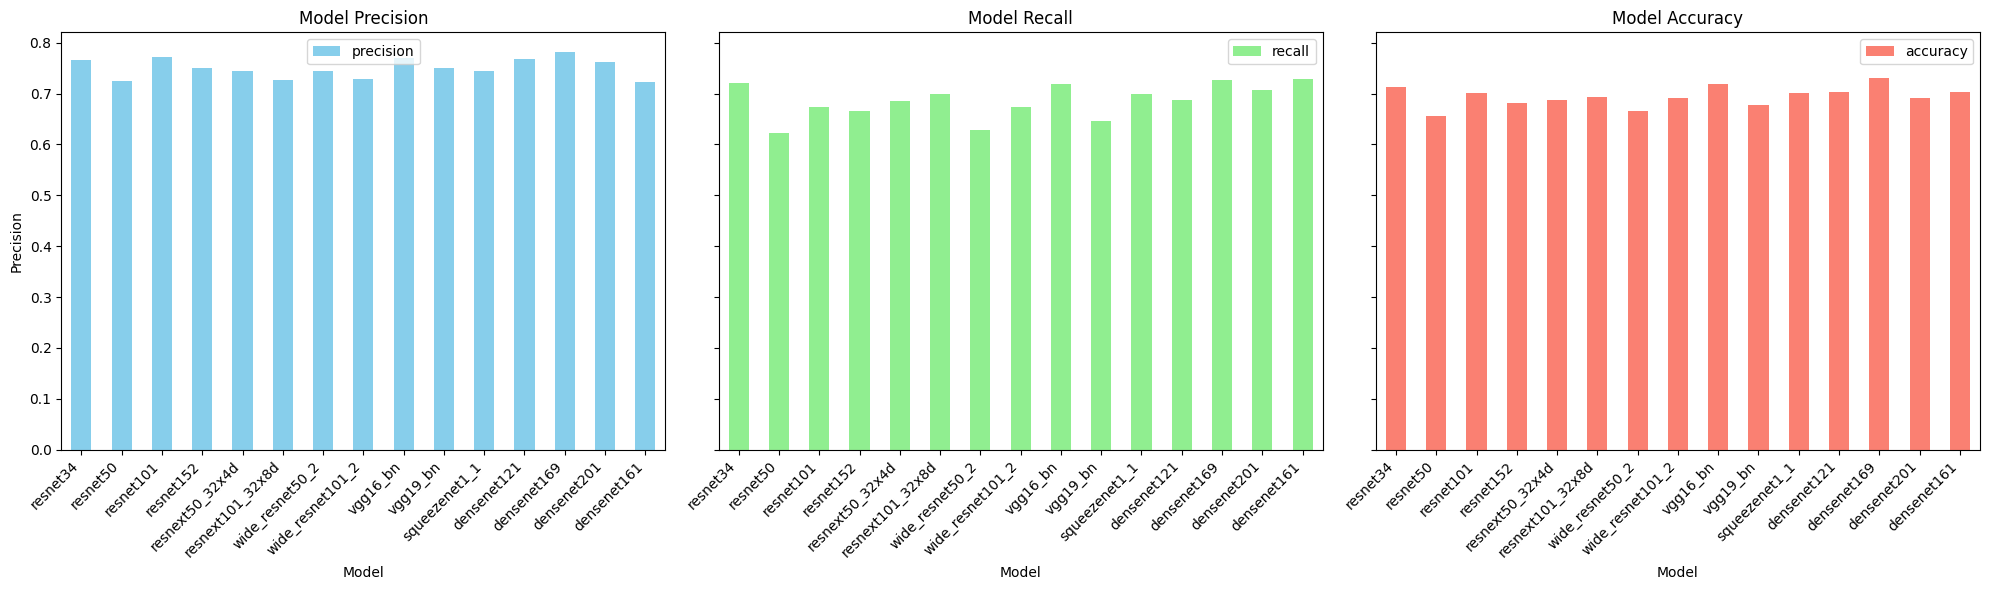

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(results)


# Set the size of the plot
plt.figure(figsize=(14, 8))

# Create subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot Precision
df.plot(kind='bar', x='model', y='precision', ax=axes[0], color='skyblue')
axes[0].set_title('Model Precision')
axes[0].set_ylabel('Precision')

# Plot Recall
df.plot(kind='bar', x='model', y='recall', ax=axes[1], color='lightgreen')
axes[1].set_title('Model Recall')

# Plot Accuracy
df.plot(kind='bar', x='model', y='accuracy', ax=axes[2], color='salmon')
axes[2].set_title('Model Accuracy')

# Set common properties
for ax in axes:
    ax.set_xlabel('Model')
    ax.set_xticklabels(df['model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()
